# Conditional Generative Adversarial Networks (cGANs)

**PHABEL ANTONIO LÓPEZ DELGADO**

In [ ]:
# Importar librerias necesarias
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.random.set_seed(0)

### 0. Funciones auxiliares

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(28, 28, 1)):
    '''
    Función para visualizar imágenes: Dado un tensor de imágenes, número de imágenes y
    tamaño por imagen, traza e imprime las imágenes en una cuadrícula uniforme.
    '''
    plt.figure()
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor[:num_images]
    image_grid = tf.concat([tf.concat([image_unflat[i*5+j] for j in range(5)], axis=1)
                          for i in range(num_images//5)], axis=0)
    plt.imshow(image_grid[:,:,0], cmap='gray')
    plt.show()

In [ ]:
def get_one_hot_labels(labels, n_classes):
    """
    Esta función transforma etiquetas categóricas numéricas en vectores binarios
    one-hot, donde cada etiqueta se representa como un vector de ceros con un único
    valor de 1 en la posición correspondiente a la clase. Esta codificación es
    fundamental para el entrenamiento de redes neuronales con múltiples clases y
    para la implementación de GANs condicionales.

    Parámetros:
    ----------
    labels : tf.Tensor o array-like
        Tensor o arreglo que contiene las etiquetas categóricas como valores
        enteros. Cada valor debe estar en el rango [0, n_classes-1]. Puede
        ser unidimensional (vector) o multidimensional según la estructura
        de datos requerida.

    n_classes : int
        Número total de clases distintas en el conjunto de datos. Define la
        dimensionalidad del espacio de salida one-hot. Debe ser mayor que el
        valor máximo presente en `labels`.
    return tf.one_hot(labels, depth=n_classes)

    Retorna:
    -------
    tf.Tensor
        Tensor de tipo float32 con representación one-hot de las etiquetas de entrada.
        La forma será (*labels.shape, n_classes), donde la última dimensión
        corresponde a la codificación binaria de cada clase.
    """
    return tf.one_hot(labels, depth=n_classes)

In [ ]:
def combine_vectors(x, y):
    """
    Concatena dos tensores vectoriales a lo largo de su última dimensión después
    de convertirlos al tipo de datos float32.

    Descripción:
    -----------
    Esta función utilitaria combina dos tensores de entrada mediante concatenación
    horizontal, asegurando compatibilidad de tipos de datos a través de conversión
    explícita a float32. Es especialmente útil en arquitecturas de redes neuronales
    donde se requiere fusionar características de diferentes fuentes, como en GANs
    condicionales, autoencoders variacionales, o modelos multimodales.

    Parámetros:
    ----------
    x : tf.Tensor o array-like
        Primer tensor de entrada que será concatenado. Puede contener características,
        embeddings, vectores latentes, o cualquier representación numérica. Su forma
        debe ser compatible con `y` en todas las dimensiones excepto la última.

    y : tf.Tensor o array-like
        Segundo tensor de entrada que será concatenado con `x`. Debe tener la misma
        forma que `x` en todas las dimensiones excepto posiblemente en la última
        dimensión (axis=-1), donde puede diferir para permitir concatenación.

    Retorna:
    -------
    tf.Tensor
        Tensor concatenado de tipo float32 con forma (*batch_dimensions, x_features + y_features).
        Contiene los elementos de `x` seguidos por los elementos de `y` a lo largo de la
        última dimensión para cada muestra del lote.
    """
    return tf.concat([tf.cast(x, tf.float32), tf.cast(y, tf.float32)], axis=-1)

In [ ]:
def get_image_one_hot_labels(one_hot_labels, n_classes, height=28, width=28):
    """
    Transforma vectores one-hot en mapas de características espaciales para su
    integración con datos de imagen en arquitecturas convolucionales.

    Descripción:
    -----------
    Esta función convierte etiquetas one-hot unidimensionales en representaciones
    bidimensionales que coinciden con las dimensiones espaciales de las imágenes.
    Cada canal del tensor resultante corresponde a una clase específica, creando
    mapas de características constantes que pueden concatenarse o combinarse con
    características de imagen en GANs condicionales, redes de segmentación semántica,
    o arquitecturas que requieren información de clase a nivel de píxel.

    Parámetros:
    ----------
    one_hot_labels : tf.Tensor
        Tensor que contiene etiquetas en formato one-hot con forma (batch_size, n_classes).
        Cada fila debe ser un vector binario con exactamente un valor 1 y (n_classes-1)
        valores 0, representando la clase correspondiente a cada muestra del lote.

    n_classes : int
        Número total de clases en el conjunto de datos. Debe coincidir con la última
        dimensión de `one_hot_labels`. Define el número de canales en el tensor de salida.

    height : int, opcional (por defecto=28)
        Altura espacial deseada para los mapas de características resultantes.
        Típicamente coincide con la altura de las imágenes del dataset (ej: 28 para MNIST,
        32 para CIFAR-10, 224 para ImageNet).

    width : int, opcional (por defecto=28)
        Anchura espacial deseada para los mapas de características resultantes.
        Debe coincidir con la anchura de las imágenes correspondientes para permitir
        operaciones de concatenación o fusión posteriores.

    Retorna:
    -------
    tf.Tensor
        Tensor de forma (batch_size, height, width, n_classes) donde cada canal
        corresponde a una clase específica. Para cada muestra, el canal de la clase
        activa contiene valores 1.0 en todas las posiciones espaciales, mientras
        que los demás canales contienen valores 0.0.
    """

    image_one_hot_labels = tf.reshape(one_hot_labels, [-1, 1, 1, n_classes]) #(batch, largo=1, ancho=1, num_clases)
    image_one_hot_labels = tf.tile(image_one_hot_labels, [1, height, width, 1])

    return image_one_hot_labels

In [ ]:
def get_noise(n_samples, z_dim):
    """
    Genera vectores de ruido aleatorio para alimentar el generador de la GAN.

    Esta función utilitaria produce muestras aleatorias del espacio latente
    que sirven como entrada al modelo generador. El ruido sigue una distribución
    normal estándar multivariada, proporcionando la diversidad estocástica
    necesaria para la generación de imágenes variadas. La función encapsula
    la generación de ruido con parámetros consistentes para reproducibilidad
    y facilidad de uso durante el entrenamiento e inferencia.

    Parámetros:
    -----------
    n_samples : int
        Número de vectores de ruido a generar. Típicamente corresponde al
        tamaño del lote (batch_size) durante el entrenamiento o al número
        de imágenes deseadas durante la generación.

    z_dim : int
        Dimensionalidad del espacio latente. Define el número de variables
        aleatorias independientes en cada vector de ruido. Debe coincidir
        con la dimensión de entrada esperada por el generador.

    Retorna:
    --------
    tf.Tensor
        Tensor de ruido aleatorio con forma (n_samples, z_dim) y dtype float32.
        Cada fila representa un vector de ruido independiente muestreado de
        la distribución normal estándar N(0, I).
    """
    return tf.random.normal(shape = (n_samples, z_dim))

## 1. Definición de modelos y carga de datos

La arquitectura GAN implementada consta de un generador basado en convoluciones transpuestas que transforma vectores de ruido de dimensión z_dim en imágenes 28x28x1 mediante una progresión 7x7x256 → 7x7x128 → 14x14x64 → 28x28x1, utilizando BatchNormalization, LeakyReLU(α=0.2) y activación tanh final para generar valores en [-1,1], mientras que el discriminador emplea convoluciones estándar con kernels 5x5 y stride=2 para reducir progresivamente las dimensiones desde 28x28x1 → 14x14x64 → 7x7x128 → vector aplanado → logit escalar, incorporando únicamente LeakyReLU(α=0.2) y Dropout(0.3) sin BatchNormalization para evitar correlaciones entre muestras del batch. A continuación se profundiza más en cada etapa.





### 1.1 Arquitectura del generador

Este generador utiliza una estructura de convolución transpuesta que incrementa progresivamente la resolución espacial: *Vector z_dim → Dense(12544) → Reshape(7,7,256) → Conv2DTranspose → Conv2DTranspose → Imagen(28,28,1)*

Capas específicas:

* Dense inicial: z_dim → 12,544 parámetros (7X7X256)
* Reshape: Vector 1D → Tensor 3D (7,7,256)
* Conv2DTranspose 1: 256→128 canales | kernel 5X5 | stride=1 (7X7)
* Conv2DTranspose 2: 128→64 canales | kernel 5X5 | stride=2 (7X7 → 14X14)
* Conv2DTranspose salida: 64→1 canal | kernel 5X5 | stride=2 (14X14 → 28X28)

Hiperparámetros:

* Kernels: 5X5
* Activación intermedia: LeakyReLU(α=0.2)
* Activación salida: Función Tanh (rango [-1,1])
* Normalización: BatchNormalization en todas las capas excepto en la de salida

Esta configuración sigue las mejores prácticas de DCGAN, balanceando estabilidad de entrenamiento con capacidad expresiva del generador y discrimidador.

**Capa de entrada y expansión inicial:**
- Input: Vector de ruido z ∈ ℝ^(z_dim)
- Dense: Transformación lineal a 7×7×256 = 12,544 características
- BatchNormalization: Normalización de activaciones para estabilidad
- LeakyReLU: Activación con pendiente negativa (α=0.2 por defecto)
- Reshape: Reconfiguración a tensor 3D (7, 7, 256)

**Bloque convolucional transpuesto 1:**
- Conv2DTranspose: 256 → 128 canales, kernel 5×5, stride 1×1
- Resolución: Mantiene 7×7 (padding='same', stride=1)
- BatchNormalization + LeakyReLU

**Bloque convolucional transpuesto 2:**
- Conv2DTranspose: 128 → 64 canales, kernel 5×5, stride 2×2
- Resolución: Upsampling 7×7 → 14×14
- BatchNormalization + LeakyReLU

**Capa de salida:**
- Conv2DTranspose: 64 → 1 canal, kernel 5×5, stride 2×2
- Resolución: Upsampling 14×14 → 28×28
- Activación: tanh (rango de salida [-1, 1])
- Sin normalización por lotes (capa final)

Progresión de resoluciones:
---------------------------
z_dim → 7×7×256 → 7×7×128 → 14×14×64 → 28×28×1

Fundamentos teóricos:
---------------------

**Convolución transpuesta:**
- Operación inversa a la convolución estándar
- Permite upsampling aprendible de características
- Preserva conectividad espacial local durante la expansión

**Normalización por lotes:**
- Estabiliza el entrenamiento adversarial
- Reduce la sensibilidad a la inicialización de pesos
- Acelera la convergencia del proceso de optimización

**Activación LeakyReLU:**
- Mitiga el problema de gradientes desvanecientes
- Permite flujo de gradiente para activaciones negativas
- Mejora la diversidad en las imágenes generadas

**Activación tanh en salida:**
- Rango de salida [-1, 1] compatible con imágenes normalizadas
- Facilita el entrenamiento adversarial estable
- Requiere preprocesamiento de datos reales al mismo rango

In [ ]:
def make_generator(z_dim):
    """
    Construye y regresa un modelo generador de red neuronal convolucional transpuesta
    para la síntesis de imágenes en el contexto de Redes Generativas Adversariales (GAN).

    Esta función implementa una arquitectura de generador profundo que transforma
    vectores de ruido aleatorio de baja dimensionalidad en imágenes sintéticas de
    alta resolución mediante el uso de capas de convolución transpuesta (deconvolución).
    El diseño sigue los principios arquitectónicos establecidos en DCGAN (Deep
    Convolutional Generative Adversarial Networks), empleando normalización por
    lotes y activaciones LeakyReLU para estabilizar el proceso de entrenamiento
    adversarial.

    Parámetros:
    -----------
    z_dim : int
        Dimensionalidad del vector de entrada, que corresponde a la concatenación del
        vector de ruido con el vector que codifica la clase (one-hot)

    Regresa:
    --------
    tf.keras.Model
        Modelo de Keras completamente configurado con las siguientes características:
        - Entrada: vector de ruido de forma (z_dim,)
        - Salida: imagen sintética de forma (28, 28, 1)
        - Nombre del modelo: 'generator'
        - Arquitectura: red convolucional transpuesta con 4 capas principales
    """
    input_layer = tf.keras.Input(shape=(z_dim,), name='inputLayer')
    ### INICIO DE CODIGO ###
    x = tf.keras.layers.Dense(12544)(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Reshape((7,7,256))(x)

    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5,
                                        strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5,
                                        strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=5,
                                        strides=2, padding='same')(x)
    output_layer = tf.keras.layers.Activation('tanh')(x)
    ### FIN DE CODIGO ###
    return tf.keras.Model(inputs = input_layer, outputs = output_layer, name = 'generator')

### 1.2 Definición del discriminador

El discriminador usa convoluciones estándar que reducen progresivamente la resolución espacial: *Imagen(28,28,1) → Conv2D → Conv2D → Flatten → Dense(1) → Logit*

Capas específicas:

* Conv2D 1: 1→64 canales | kernel 5X5 | stride=2 (28X28 → 14X14)
* Conv2D 2: 64→128 canales | kernel 5X5 | stride=2 (14X14 → 7X7)
* Flatten: (7,7,128) → Vector(6,272)
* Dense: 6,272 → 1 logit

Hiperparámetros del Discriminador:

* Kernels: 5X5
* Activación: LeakyReLU(α=0.2)
* Regularización: Dropout(0.3) después de cada Conv2D
* Normalización: Sin BatchNormalization
* Salida: Sin activación

Esta configuración sigue las mejores prácticas de DCGAN, balanceando estabilidad de entrenamiento con capacidad expresiva del generador y discriminador.

**Capa de entrada:**
- Input: Imagen I ∈ ℝ^(28×28×1) (escala de grises)
- Compatibilidad: Imágenes MNIST y dominios similares
- Rango esperado: [-1, 1] (compatible con salida tanh del generador)

**Bloque convolucional 1 - Extracción de características de bajo nivel:**
- Conv2D: 1 → 64 canales, kernel 5×5, stride 2×2
- Resolución: Downsampling 28×28 → 14×14
- LeakyReLU(α=0.2): Activación con pendiente negativa para gradientes estables
- Dropout(0.3): Regularización estocástica para prevenir sobreajuste
- **Propósito**: Detección de bordes, texturas y patrones locales

**Bloque convolucional 2 - Extracción de características de alto nivel:**
- Conv2D: 64 → 128 canales, kernel 5×5, stride 2×2
- Resolución: Downsampling 14×14 → 7×7
- LeakyReLU(α=0.2): Mantenimiento de gradientes para entrenamiento estable
- Dropout(0.3): Regularización adicional en capas profundas
- **Propósito**: Composición de características complejas y semánticas

**Capa de clasificación:**
- Flatten: Conversión de tensor 3D (7×7×128) a vector 1D (6,272 elementos)
- Dense: Transformación lineal a logit escalar único
- **Sin activación**: Salida en forma de logit para flexibilidad en función de pérdida
- **Interpretación**: Valor positivo → imagen real, valor negativo → imagen sintética

Progresión arquitectónica:
--------------------------
(28,28,1) → (14,14,64) → (7,7,128) → (6272,) → (1,)

Fundamentos teóricos:
---------------------

**Convolución con stride:**
- Reduce dimensionalidad espacial mientras preserva información relevante
- Implementa pooling implícito más eficiente que max-pooling explícito
- Permite aprendizaje de filtros de downsampling específicos para la tarea

**Activación LeakyReLU:**
- Función: f(x) = max(αx, x) con α = 0.2
- Ventajas: Previene muerte neuronal, mantiene gradientes para x < 0
- Crítico en discriminadores: Evita saturación durante entrenamiento adversarial

**Regularización por Dropout:**
- Desactivación estocástica del 30% de neuronas durante entrenamiento
- Reduce co-adaptación entre características aprendidas
- Mejora generalización y previene memorización de muestras específicas

**Ausencia de Batch Normalization:**
- Decisión arquitectónica deliberada en discriminadores GAN
- Evita correlaciones indeseadas entre muestras del lote
- Preserva la capacidad discriminativa individual por muestra

In [ ]:
def make_discriminator(im_chan=1):
    """
    Construye y retorna un modelo discriminador de red neuronal convolucional
    para clasificación binaria en el contexto de Redes Generativas Adversariales (GAN).

    Esta función implementa una arquitectura de discriminador profundo que evalúa
    la autenticidad de imágenes, distinguiendo entre muestras reales del conjunto
    de datos y muestras sintéticas generadas por el modelo generador. El diseño
    emplea una estructura convolucional descendente que reduce progresivamente
    la resolución espacial mientras incrementa la profundidad de características,
    culminando en una decisión binaria de clasificación. La arquitectura incorpora
    técnicas de regularización mediante dropout y activaciones LeakyReLU para
    mejorar la robustez y estabilidad del entrenamiento adversarial.

    Parámetros:
    -----------
    im_chan : int, opcional (por defecto=1)
        Número de canales de la imagen de entrada. Utilice 1 para imágenes en
        escala de grises y 3 para imágenes a color (RGB). Debe coincidir con
        el formato de salida del generador correspondiente.

    Retorna:
    --------
    tf.keras.Model
        Modelo de Keras completamente configurado con las siguientes características:
        - Entrada: imagen de forma (28, 28, 1)
        - Salida: logit escalar para clasificación binaria real/sintético
        - Nombre del modelo: 'discriminator'
        - Arquitectura: red convolucional con 2 capas de extracción + clasificador
    """

    input_layer = tf.keras.Input(shape = (28,28,im_chan), name = 'inputLayer')
    ### INICIO DE CODIGO ###
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=5,strides = 2)(input_layer)

    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=5,strides=2)(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)

    ### FIN DE CÓDIGO ###
    output_layer = tf.keras.layers.Dense(1, name = 'outputLayer')(x)

    return tf.keras.Model(inputs = input_layer, outputs = output_layer, name = 'discriminator')

### 1.3 Carga de datos

In [ ]:
# Cargar y preparar datos MNIST
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalizar a [-1, 1]

batch_size = 128
# Crear dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(60000).batch(batch_size, drop_remainder=True)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Al ejecutar la siguiente celda, crearemos los modelos para el generador y el discriminador. Nota que el generador ahora utiliza un vector de entrada que es la concatenación del vector de ruido con el vector *one-hot*. De manera similar, el número de canales de la imagen de entrada al discriminador es igual a los canales originales (1, en el caso de imágenes en escala de grises) y el número de categorías en el vector de tipo *one-hot*.

In [ ]:
z_dim = 64
n_classes = 10

generator_input_dim = z_dim + n_classes
discriminator_im_chan = train_images.shape[-1] + n_classes

generator = make_generator(generator_input_dim)
discriminator = make_discriminator(discriminator_im_chan)

generator.summary()
discriminator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 74)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12544)          │       940,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,017,537 (7.70 MB)

 Trainable params: 1,992,065 (7.60 MB)

 Non-trainable params: 25,472 (99.50 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 28, 28, 11)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 12, 12, 64)     │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,641 (877.50 KB)

 Trainable params: 224,641 (877.50 KB)

 Non-trainable params: 0 (0.00 B)

## 2. Funciones de pérdida para el discriminador y el generador

En el marco de las redes generativas antagónicas (GANs), las funciones de pérdida desempeñan un papel central en la dinámica de entrenamiento adversario. El **discriminador** busca distinguir correctamente entre muestras reales (provenientes del conjunto de datos) y muestras generadas (producidas por el generador), mientras que el **generador** trata de engañar al discriminador produciendo muestras que sean lo más realistas posible.

- **Pérdida del discriminador:**  
  Suele utilizarse la función de entropía cruzada binaria. El discriminador intenta maximizar la probabilidad de asignar la etiqueta correcta a las imágenes reales (generalmente etiqueta 1) y a las imágenes generadas (etiqueta 0). En la práctica, el objetivo se formula como una minimización, por lo que la función de pérdida mide el error en la clasificación de ambas clases.
$$
\mathcal{L}_D = - \mathbb{E}_{\mathbf{x} \sim p_{\text{datos}}} [\log D(\mathbf{x})] - \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}} [\log (1 - D(G(\mathbf{z})))] $$
- **Pérdida del generador:**  
  El generador intenta maximizar la probabilidad de que el discriminador clasifique las imágenes generadas como reales. Esto se logra, típicamente, minimizando la entropía cruzada entre la salida del discriminador para imágenes falsas y la etiqueta de imagen real.

Esta configuración de pérdidas fomenta la competencia entre ambos modelos, propiciando que el generador produzca muestras cada vez más realistas.
$$\mathcal{L}_G = - \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}} [\log D(G(\mathbf{z}))]$$



donde:
- $D(\mathbf{x})$ es la probabilidad estimada por el discriminador de que la muestra $\mathbf{x}$ sea real,
- $G(\mathbf{z})$ es la muestra generada a partir del vector de ruido $\mathbf{z}$.

Las funciones de pérdida implementan la formulación adversarial clásica donde el discriminador minimiza L_D = -E[log D(x)] - E[log(1-D(G(z)))] mediante entropía cruzada binaria con etiquetas 1 para imágenes reales y 0 para falsas, mientras el generador minimiza L_G = -E[log D(G(z))] intentando que sus imágenes sintéticas sean clasificadas como reales (etiqueta 1), estableciendo así la dinámica competitiva característica de las GANs donde ambos modelos se entrenan simultáneamente hasta alcanzar un equilibrio.



In [ ]:
# Funciones de pérdida
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    """
    Calcula la función de pérdida del discriminador en el marco de entrenamiento
    adversarial de Redes Generativas Adversariales (GAN).

    Esta función implementa la pérdida binaria estándar del discriminador, que
    busca maximizar su capacidad para distinguir entre imágenes reales y sintéticas.
    La formulación combina dos componentes: la pérdida en muestras reales (que
    deben clasificarse como verdaderas) y la pérdida en muestras generadas (que
    deben clasificarse como falsas). El objetivo es entrenar un clasificador
    binario robusto que sirva como adversario efectivo para el generador.

    Parámetros:
    -----------
    real_output : tf.Tensor
        Logits de salida del discriminador para imágenes reales del conjunto
        de datos. Forma esperada: (batch_size, 1). Valores positivos indican
        clasificación como "real", valores negativos como "sintético".

    fake_output : tf.Tensor
        Logits de salida del discriminador para imágenes sintéticas generadas
        por el modelo generador. Forma esperada: (batch_size, 1). El discriminador
        debe aprender a asignar valores negativos a estas muestras.

    Retorna:
    --------
    tf.Tensor
        Pérdida total del discriminador como valor escalar. Representa la suma
        de las pérdidas en muestras reales y sintéticas, lista para optimización
        mediante descenso de gradiente.
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """
    Calcula la función de pérdida del generador en el contexto de entrenamiento
    adversarial de Redes Generativas Adversariales (GAN).

    Esta función implementa la pérdida adversarial del generador, cuyo objetivo
    es engañar al discriminador para que clasifique las imágenes sintéticas como
    reales. La formulación utiliza entropía cruzada binaria con etiquetas objetivo
    de "verdadero" para todas las muestras generadas, incentivando al generador
    a producir imágenes cada vez más realistas que confundan al discriminador.

    Parámetros:
    -----------
    fake_output : tf.Tensor
        Logits de salida del discriminador evaluando imágenes sintéticas generadas
        por el modelo generador. Forma esperada: (batch_size, 1). El generador
        busca que estos valores sean positivos (clasificación como "real").

    Retorna:
    --------
    tf.Tensor
        Pérdida del generador como valor escalar. Cuantifica qué tan exitoso
        es el generador en engañar al discriminador, lista para optimización
        mediante descenso de gradiente.
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)


## 3. Rutina de ajuste

1. **Generación de ruido y preparación de etiquetas:**
   - Muestreo de vectores latentes aleatorios z ~ N(0,I)
   - Conversión de etiquetas categóricas a formato one-hot
   - Expansión espacial de etiquetas para concatenación con imágenes

2. **Forward pass dual (Propagación hacia adelante):**
   - Generación de imágenes sintéticas: G(z|y) donde y son las etiquetas
   - Evaluación discriminativa de imágenes reales: D(x|y)
   - Evaluación discriminativa de imágenes sintéticas: D(G(z|y)|y)

3. **Cálculo de pérdidas adversariales:**
   - Pérdida del generador: $L_G = -log D(G(z|y)|y)$
   - Pérdida del discriminador: $L_D = -log D(x|y) - log(1 - D(G(z|y)|y))$

4. **Backward pass dual (Retropropagación):**
   - Gradientes del generador: $∇_{θ_G} L_G$
   - Gradientes del discriminador: $∇_{θ_D} L_D$  

5. **Actualización de parámetros:**
   - $θ_G ← θ_G - α_G ∇_{θ_G} L_G$
   - $θ_D ← θ_D - α_D ∇_{θ_D} L_D$

In [ ]:
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

# Optimizadores
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=beta_1, beta_2=beta_2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=beta_1, beta_2=beta_2)

In [ ]:
@tf.function
def train_step(images, labels):

    """
    Ejecuta un paso completo de entrenamiento adversarial para la GAN.

    Esta función implementa el núcleo del algoritmo de entrenamiento adversarial,
    realizando la actualización simultánea de generador y discriminador mediante
    diferenciación automática. El proceso incluye la generación de imágenes
    sintéticas, evaluación discriminativa, cálculo de pérdidas adversariales
    y actualización de parámetros mediante optimización basada en gradientes.
    La decoración @tf.function compila la función en un grafo computacional
    optimizado para ejecución eficiente.

    Parámetros:
    -----------
    images : tf.Tensor
        Lote de imágenes reales del conjunto de datos de entrenamiento.
        Forma esperada: (batch_size, height, width, channels).
        Rango de valores: [-1, 1] (compatible con activación tanh del generador).

    Retorna:
    --------
    tuple
        Tupla de dos elementos conteniendo las pérdidas calculadas:

        gen_loss : tf.Tensor
            Pérdida del generador en el paso actual de entrenamiento.

        disc_loss : tf.Tensor
            Pérdida del discriminador en el paso actual de entrenamiento.
    """
    noise = get_noise(batch_size, z_dim)
    one_hot_labels = get_one_hot_labels(labels, n_classes)
    image_one_hot_labels = get_image_one_hot_labels(one_hot_labels, n_classes)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        noise_and_labels = combine_vectors(noise, one_hot_labels)
        generated_images = generator(noise_and_labels, training=True)

        real_concat = combine_vectors(images, image_one_hot_labels)
        fake_concat = combine_vectors(generated_images, image_one_hot_labels)

        real_output = discriminator(real_concat, training=True)
        fake_output = discriminator(fake_concat, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

En la siguiente bloque de código se define un bucle de entrenamiento utilizando la función `train_step`.

In [ ]:
def train(dataset, epochs, display_step = 500):

    """
    Ejecuta el bucle completo de entrenamiento adversarial para la GAN.

    Esta función implementa el procedimiento de entrenamiento de alto nivel
    para Redes Generativas Adversariales, coordinando múltiples épocas de
    entrenamiento con monitoreo de progreso y visualización periódica de
    resultados. El proceso incluye iteración sobre el conjunto de datos,
    ejecución de pasos de entrenamiento adversarial, registro de métricas
    y generación de muestras para evaluación cualitativa del progreso.

    Parámetros:
    -----------
    dataset : tf.data.Dataset
        Conjunto de datos de entrenamiento configurado con lotes, mezcla
        y preprocesamiento apropiados. Debe producir lotes de imágenes
        con forma (batch_size, height, width, channels) y rango [-1, 1].

    epochs : int
        Número total de épocas de entrenamiento. Una época constituye un
        pase completo a través de todo el conjunto de datos disponible.
    """
    for epoch in range(epochs):
        for i, (image_batch, label_batch) in enumerate(dataset):

            gen_loss, disc_loss = train_step(image_batch, label_batch)

            if i % display_step == 0:
                print(f"Epoch {epoch}, Batch {i}, Generator loss: {gen_loss}, Discriminator loss: {disc_loss}")

                # Mostrar imágenes generadas
                test_noise = get_noise(25, z_dim)
                test_labels = tf.range(25) % n_classes
                test_one_hot = get_one_hot_labels(test_labels, n_classes)
                test_input = combine_vectors(test_noise, test_one_hot)
                fake_images = generator(test_input, training=False)
                show_tensor_images(fake_images)


### 4. Entrenamiento del modelo

La diferencia fundamental entre estos tres tipos de GAN radica en el nivel de control y la arquitectura: la GAN original utiliza redes totalmente conectadas y genera contenido completamente aleatorio sin dirigir el tipo de salida; la DCGAN introduce convoluciones transpuestas y técnicas como BatchNormalization y LeakyReLU que mejoran significativamente la calidad visual y estabilidad del entrenamiento, pero mantiene la generación aleatoria sin control; mientras que la GAN Condicional (cGAN) incorpora información adicional de etiquetas o clases tanto en el generador (concatenando el vector de ruido z con un vector one-hot de clase y) como en el discriminador (que evalúa tanto autenticidad como coherencia con la etiqueta) mediante vectores one-hot, permitiendo así generar contenido específico dirigido por clase, donde el usuario puede especificar exactamente qué tipo de imagen desea generar. Esto último, transforma la generación de un proceso completamente aleatorio a uno controlado y dirigido por objetivos. Esto puede ayudar en la utilidad práctica de las GANs para aplicaciones controladas e incluso a un nivel de clasificación.

Los hiperparámetros del entrenamiento GAN implementado utilizaron el optimizador ADAM con una tasa de aprendizaje de 0.0002, *beta_1* de 0.5, *beta_2* de 0.999, y un batch size de 128 muestras por lote que proporciona un balance entre estabilidad estadística del gradiente y eficiencia computacional. Se entrenó durante 5 épocas por razones de practicidad con un display_step de 500 para monitorear el progreso cada 500 batches. La tasa de aprendizaje fue conservadora y previno oscilaciones excesivas en la dinámica adversarial dado el número de épocas. El beta_1 reducido disminuyó la inercia en las actualizaciones de gradientes y facilitó la convergencia estable de ambos modelos competitivos. El tamaño de lote fue suficiente para estimaciones robustas de gradiente sin sobrecargar recursos computacionales dadas las 5 épocas entrenadas. Dando resultados decentes que seguramente mejorarían si se tuviera mayor número de épocas y se hiciera una optimización de hiperparámetros.


Epoch 0, Batch 0, Generator loss: 0.7107454538345337, Discriminator loss: 1.377547264099121


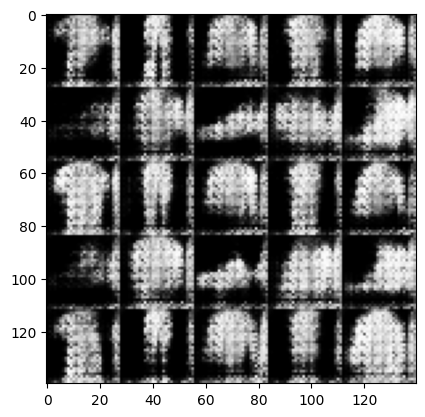

Epoch 1, Batch 0, Generator loss: 0.7024618983268738, Discriminator loss: 1.384177803993225


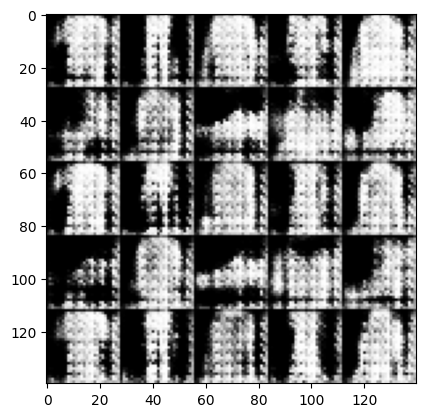

Epoch 2, Batch 0, Generator loss: 0.7228294014930725, Discriminator loss: 1.3387792110443115


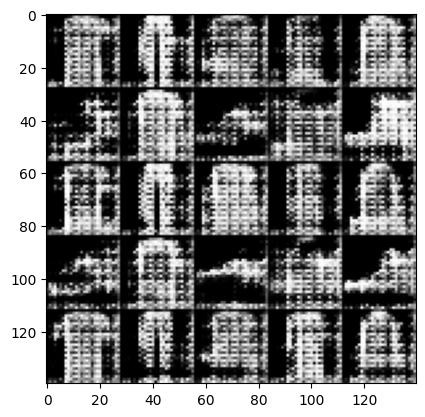

Epoch 3, Batch 0, Generator loss: 0.7521281838417053, Discriminator loss: 1.339576244354248


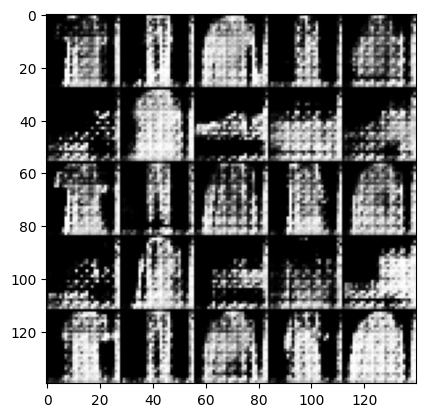

Epoch 4, Batch 0, Generator loss: 0.7677889466285706, Discriminator loss: 1.34534752368927


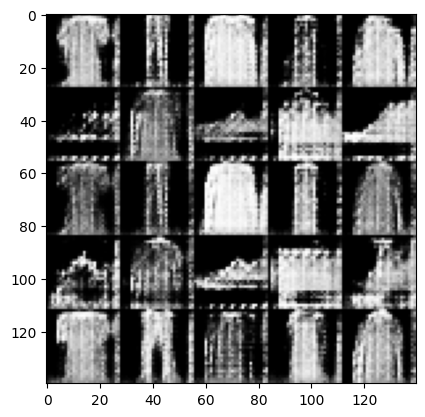

In [ ]:
# Entrenar el modelo
epochs = 5
train(dataset=train_dataset, epochs=epochs)

# Guardar modelos
#generator.save('cgan_generator.h5')
#discriminator.save('cgan_discriminator.h5')

### 5. Interpolación entre clases

In [ ]:
def interpolate_class(first_number, second_number, n_interpolation=9):
    """

    Esta función implementa interpolación lineal en el espacio de etiquetas para
    visualizar la transición gradual entre diferentes clases en un modelo GAN
    condicional. Mantiene constante el vector de ruido latente mientras modifica
    progresivamente la información de clase, permitiendo observar cómo el generador
    transforma características específicas de una clase hacia otra. Esta técnica
    es fundamental para evaluar la calidad del aprendizaje de representaciones
    y la suavidad del espacio latente condicional.

    Parámetros:
    ----------
    first_number : int
        Identificador numérico de la primera clase en la secuencia de interpolación.
        Debe estar en el rango [0, n_classes-1]. Representa el punto de inicio
        de la transición, donde la influencia de esta clase será máxima (100%).

    second_number : int
        Identificador numérico de la segunda clase en la secuencia de interpolación.
        Debe estar en el rango [0, n_classes-1]. Representa el punto final de
        la transición, donde la influencia de esta clase será máxima (100%).

    n_interpolation : int, opcional (por defecto=9)
        Número total de pasos de interpolación a generar, incluyendo los extremos.
        Determina la granularidad de la transición: valores más altos producen
        transiciones más suaves pero requieren mayor tiempo de cómputo.

    Variables Globales Requeridas:
    -----------------------------
    - generator: Modelo generador entrenado
    - z_dim: Dimensión del espacio latente
    - n_classes: Número total de clases en el dataset
    - show_tensor_images: Función de visualización
    """

    # 1. Generación de ruido constante para toda la secuencia
    interpolation_noise = get_noise(1, z_dim)
    interpolation_noise = tf.tile(interpolation_noise, [n_interpolation, 1])

    # 2. Preparación de etiquetas extremas en formato one-hot
    first_label = get_one_hot_labels(tf.constant([first_number]), n_classes)
    second_label = get_one_hot_labels(tf.constant([second_number]), n_classes)

    # 3. Cálculo de pesos de interpolación lineal
    percent_second_label = tf.linspace(0., 1., n_interpolation)[:, tf.newaxis]

    # 4. Interpolación entre etiquetas extremas
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # 5. Combinación de ruido constante con etiquetas interpoladas
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels)

    # 6. Generación de secuencia de imágenes interpoladas
    fake = generator(noise_and_labels)
    # 7. Visualización de la secuencia de interpolación
    for i in range(fake.shape[0]):

        plt.figure(figsize=(1,1))
        plt.title(f"{first_number}={interpolation_labels[i,first_number]}, {second_number}={interpolation_labels[i,second_number]}")
        plt.imshow(fake[i,:,:,0], cmap='gray')
        plt.show()


### Tarea V: Generar cinco imágenes con el generador entrenado utilizando una interpolación de clases con un mismo vector de ruido (2 pts)

<Figure size 800x800 with 0 Axes>

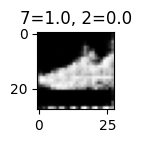

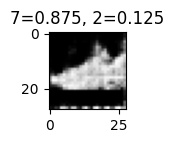

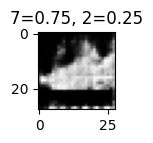

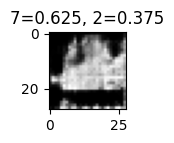

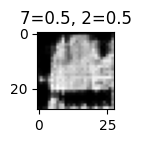

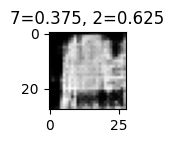

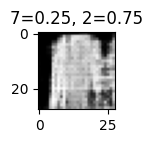

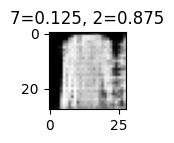

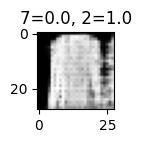

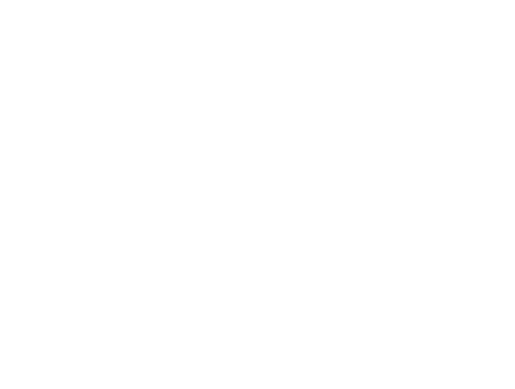

In [ ]:
plt.figure(figsize=(8, 8))
interpolate_class(7, 2)  # Cambia estos números para probar diferentes interpolaciones
_ = plt.axis('off')

### 6. Interpolación entre ruidos

In [ ]:
def interpolate_noise(first_noise, second_noise, n_interpolation=9):
    """
    Esta función implementa interpolación lineal en el espacio latente de ruido
    para explorar la continuidad y estructura del espacio de representaciones
    aprendido por el generador GAN. Mantiene fija la información de clase mientras
    modifica gradualmente el vector latente, permitiendo observar cómo pequeños
    cambios en el espacio latente se traducen en variaciones semánticas coherentes
    en el espacio de imágenes. Esta técnica es esencial para evaluar la calidad
    del mapeo latente-imagen y detectar discontinuidades o artefactos.

    Parámetros:
    ----------
    first_noise : tf.Tensor
        Vector de ruido inicial en el espacio latente con forma (1, z_dim).
        Representa el punto de partida de la interpolación, donde su influencia
        será mínima (0%) al inicio y máxima (100%) al final de la secuencia.

    second_noise : tf.Tensor
        Vector de ruido final en el espacio latente con forma (1, z_dim).
        Representa el punto de destino de la interpolación, donde su influencia
        será máxima (100%) al inicio y mínima (0%) al final de la secuencia.

    n_interpolation : int, opcional (por defecto=9)
        Número total de pasos de interpolación a generar, incluyendo los extremos.
        Controla la granularidad de la transición: valores más altos producen
        transiciones más suaves pero incrementan el costo computacional.

    Variables Globales Requeridas:
    -----------------------------
    - generator: Modelo generador entrenado
    - n_classes: Número total de clases en el dataset
    - show_tensor_images: Función de visualización de tensores
    """

    # 1. Preparación de etiqueta constante para toda la secuencia
    interpolation_label = get_one_hot_labels(tf.constant([9]), n_classes)
    interpolation_label = tf.tile(interpolation_label, [n_interpolation, 1])

    # 2. Cálculo de pesos de interpolación lineal
    percent_first_noise = tf.linspace(0., 1., n_interpolation)[:, tf.newaxis]

    # 3. Interpolación lineal entre vectores de ruido extremos
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # 4. Combinación de ruido interpolado con etiqueta constante
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label)

    # 5. Generación de secuencia de imágenes con ruido interpolado
    fake = generator(noise_and_labels)

    # 6. Visualización de la secuencia de interpolación latente

    show_tensor_images(fake, num_images=n_interpolation)#, nrow=int(np.sqrt(n_interpolation)), show=False)

### Tarea VI: Generar cinco imágenes con el generador entrenado utilizando diferentes vectores de ruido para una misma clase (2 pts)

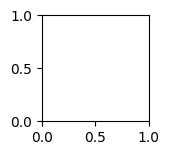

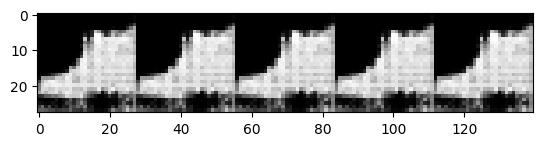

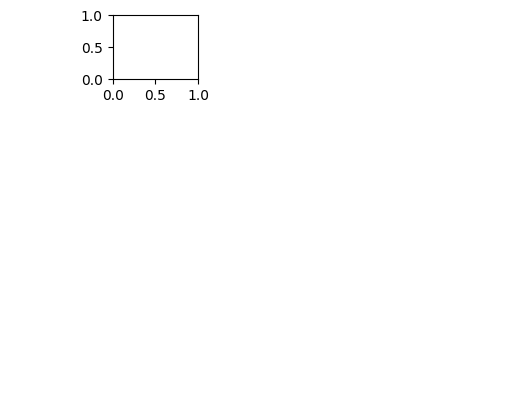

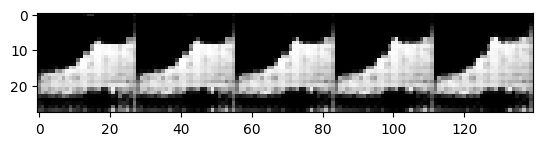

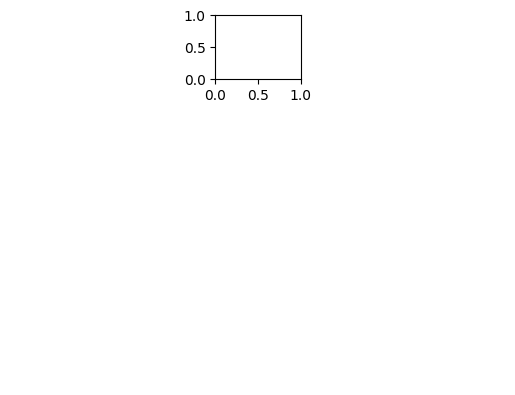

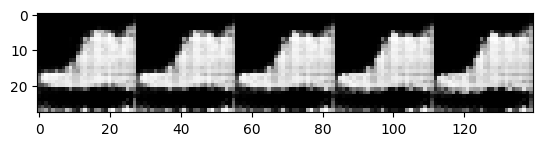

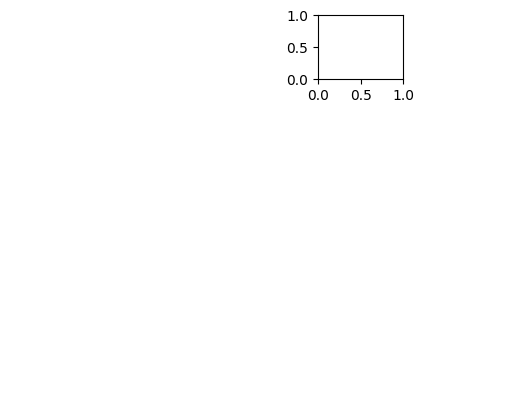

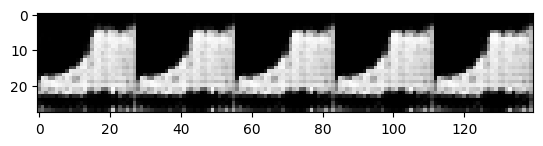

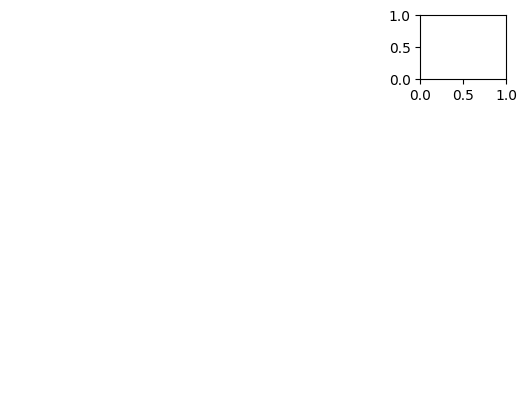

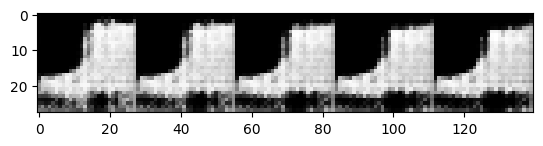

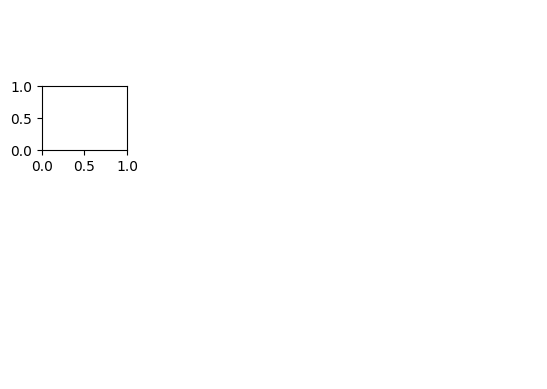

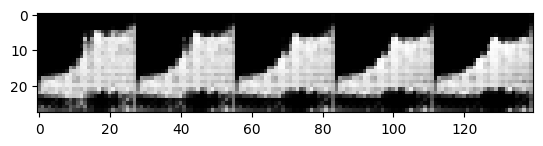

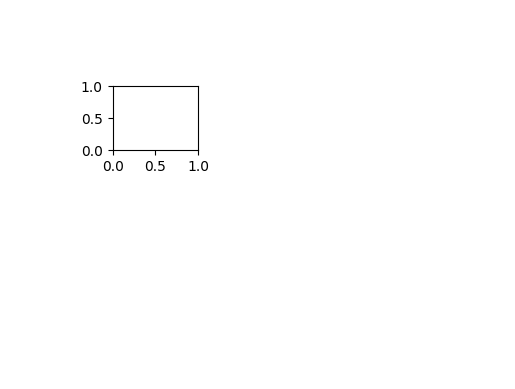

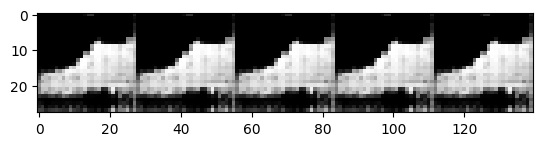

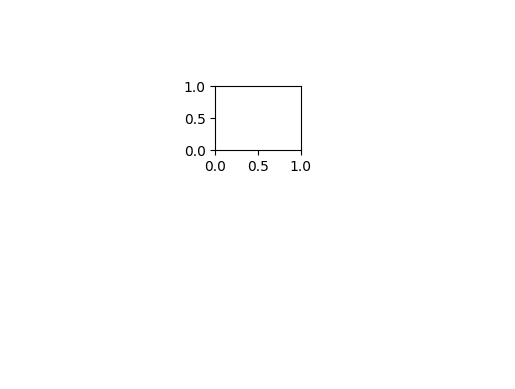

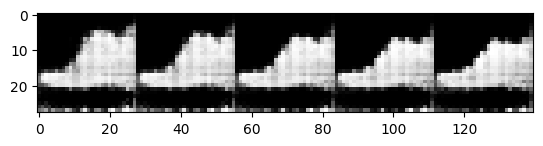

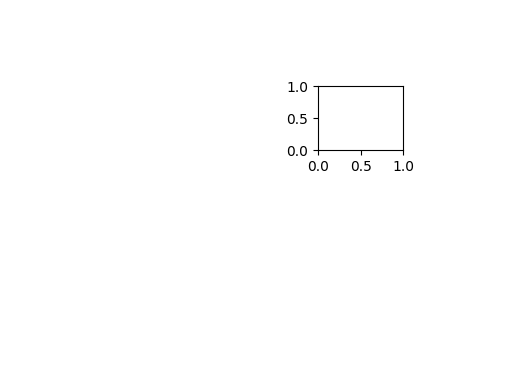

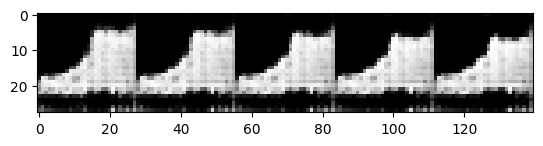

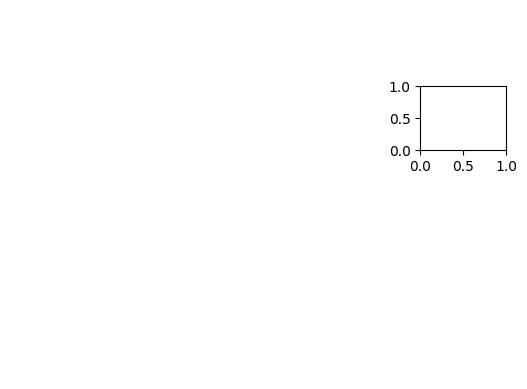

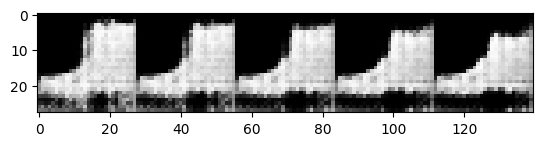

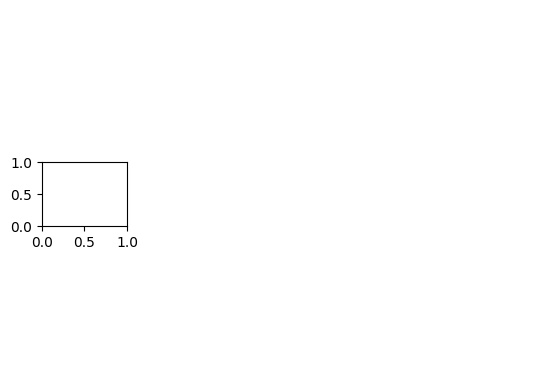

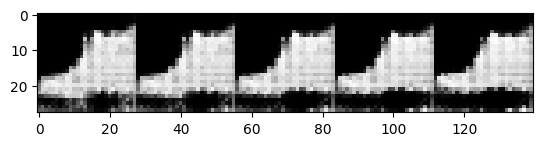

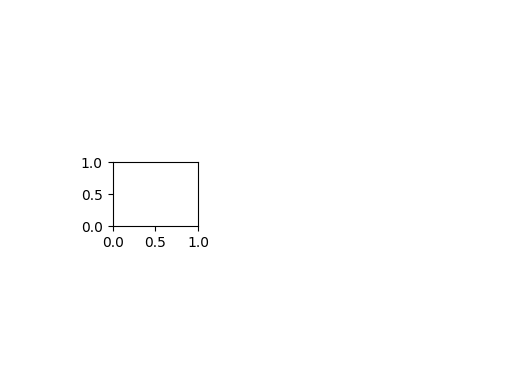

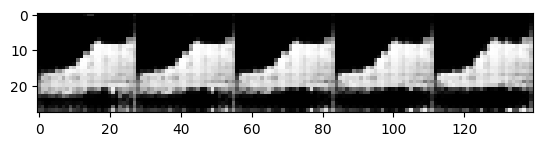

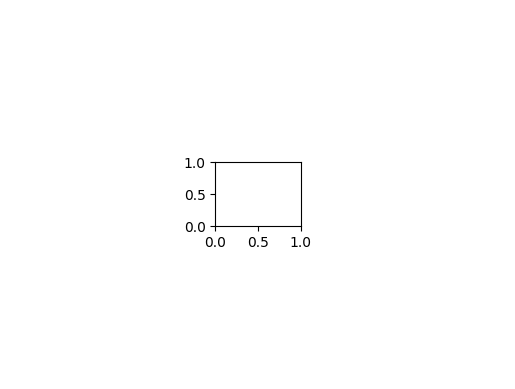

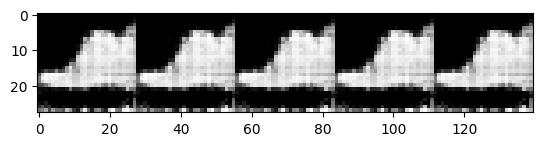

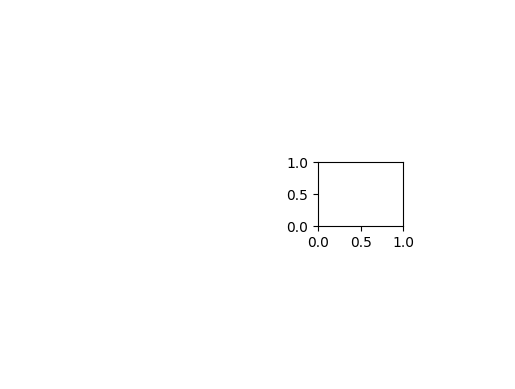

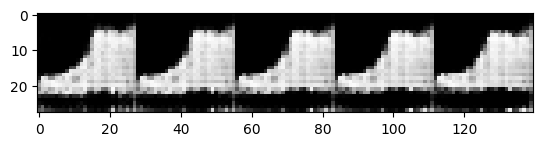

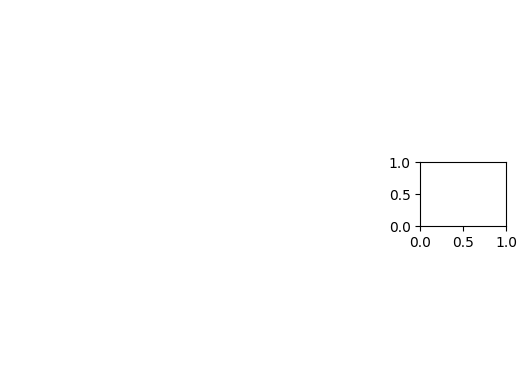

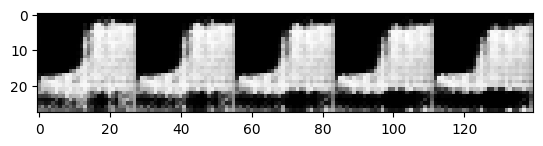

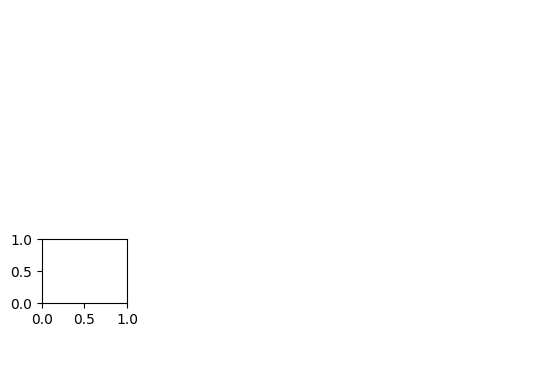

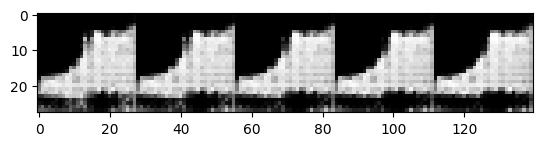

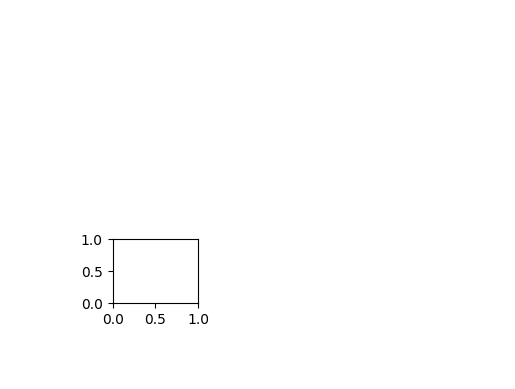

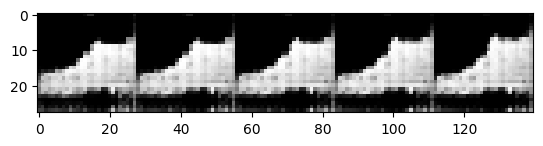

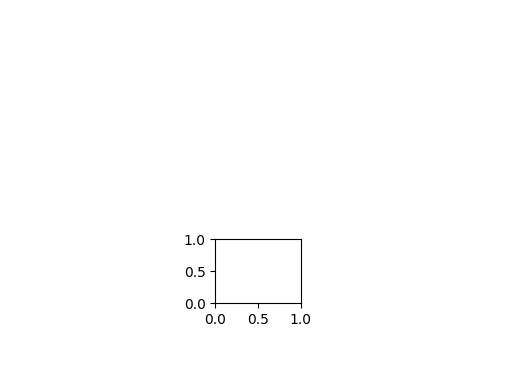

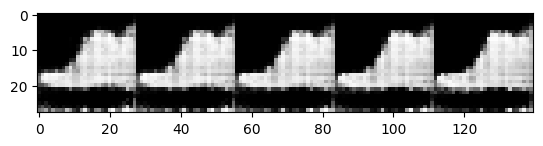

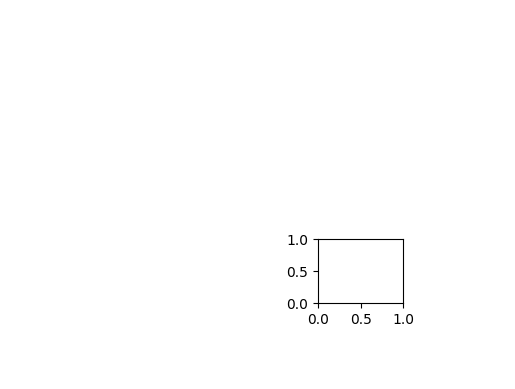

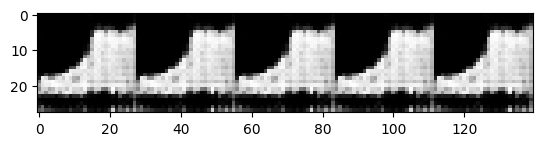

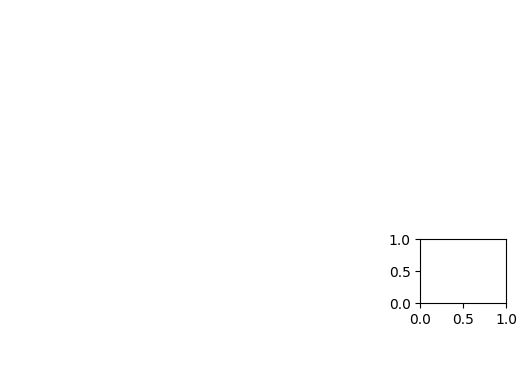

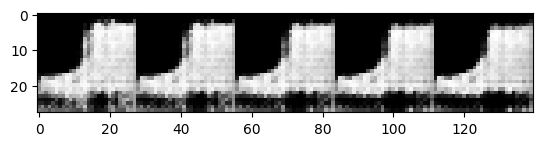

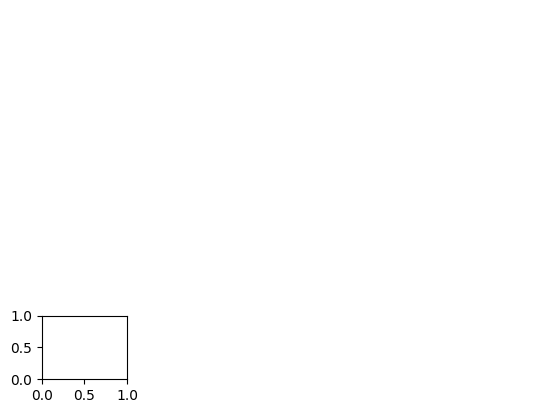

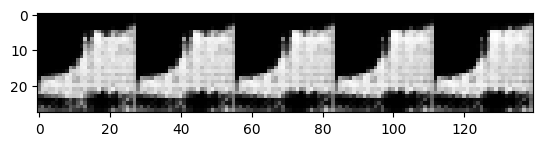

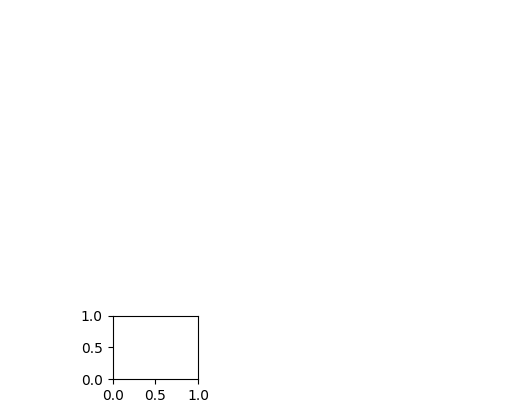

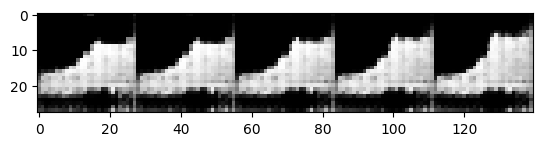

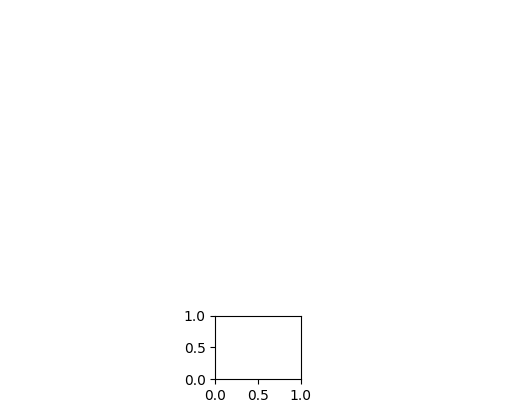

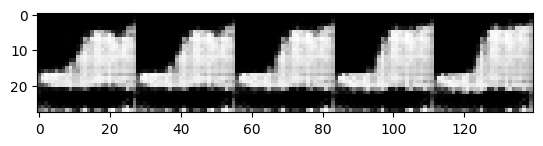

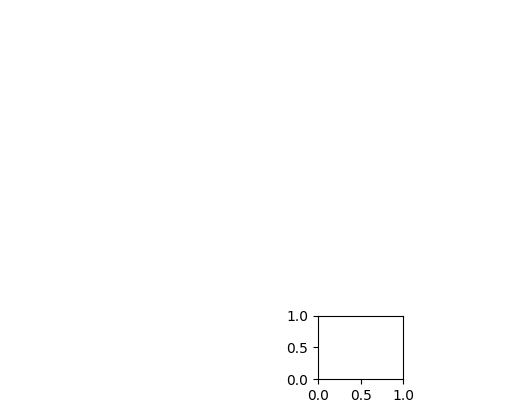

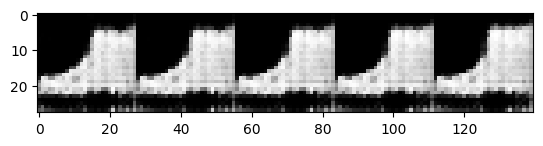

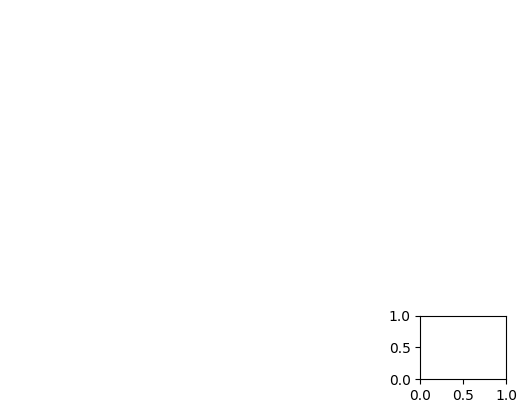

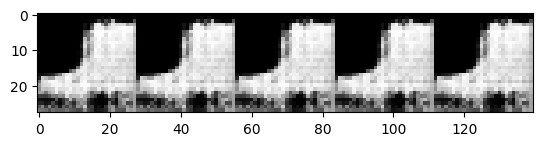

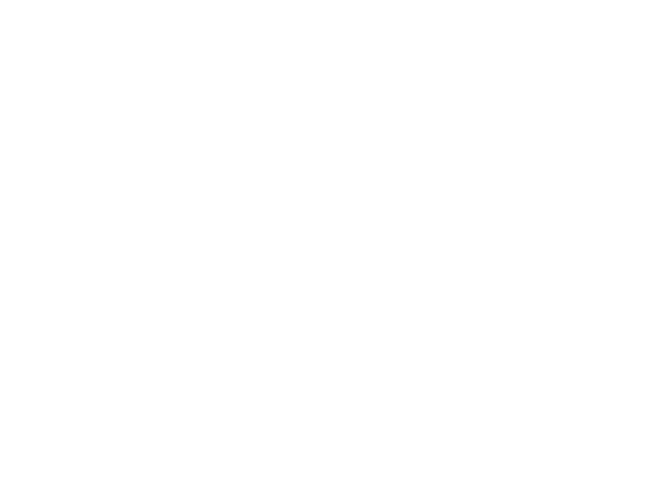

In [ ]:
n_noise = 5
plot_noises = [get_noise(1, z_dim) for _ in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

## Conclusiones

En conclusión, la implementación de esta cGAN demuestra la evolución arquitectónica desde las redes generativas básicas hasta modelos más sofisticados y controlables. Cabe destacar que la arquitectura DCGAN implementada, con su generador basado en convoluciones transpuestas que progresa desde vectores de ruido de baja dimensionalidad hasta imágenes 28x28 de alta calidad, y su discriminador convolucional que emplea técnicas de regularización como dropout y activaciones LeakyReLU, representa un balance efectivo entre calidad de síntesis y estabilidad de entrenamiento. Asimismo, las funciones de pérdida adversariales implementadas mediante entropía cruzada binaria establecen correctamente la dinámica competitiva donde el discriminador aprende a distinguir entre muestras reales y falsas mientras el generador perfecciona su capacidad de engaño; pero sin llegar aun punto muerto de oscilación.

La diferencia fundamental con las cGANs condicionales radica en la incorporación de información de etiquetas que transforma la generación de un proceso totalmente aleatorio a uno dirigido y controlable; permitiendo así  síntesis específica por clase. Los hiperparámetros seleccionados, incluyendo el optimizador ADAM con una tasa de aprendizaje conservadora de 0.0002 y beta_1=0.5, junto con un batch size de 128 y entrenamiento limitado a 5 épocas, reflejan buenas prácticas para el entrenamiento estable de cGANs. Si bien, el número reducido de épocas puede limitar la convergencia completa del modelo y la calidad final de las imágenes generadas, fue suficiente para lograr el objetivo buscado de generar imágenes. Entrenamientos más extensos seguramente aprovecharían todo el potencial de esta arquitectura.